In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

2024-04-20 15:05:52.435691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Prep Data

In [2]:
dataIn = pd.read_csv('complete_fiscal_data.csv')


In [3]:
train_data = dataIn.loc[dataIn['year'] == 2019,:]
test_data = dataIn.loc[dataIn['year'] == 2022,:]


train_x = train_data.iloc[:,11:161]
test_x = test_data.iloc[:,11:161]

# normalize data
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(train_x) 
train_x.loc[:,:] = scaled_values
scaled_values2 = scaler.fit_transform(test_x) 
test_x.loc[:,:] = scaled_values2

train_y_math = train_data['outperform_math']
train_y_reading = train_data['outperform_reading']
test_y_math = train_data['outperform_math']
test_y_reading = train_data['outperform_reading']


/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_6844/71131141.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_x.loc[:,:] = scaled_values
/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_6844/71131141.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_x.loc[:,:] = scaled_values2


# Basic ANN

## LARGE MATH

In [5]:
import keras
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras.optimizers import RMSprop

# Hyper parameters
L1=0
L2=1e-3
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=5)


# create a sequential model once again
model = Sequential()
model.add(layers.Dense(256, activation='relu',input_shape=[150,]))
# This layer is the recurent layer, which returns all previous data
model.add(layers.Dense(256, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(256, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
model.add(layers.Dropout(rate=0.5))

#model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
#model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))


# layer that reads the recurent layer
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer=RMSprop(learning_rate = 0.0001), loss='mse')


test_one = model.fit(x = train_x, y = train_y_math, steps_per_epoch = 51, epochs=200, batch_size = 1,callbacks=[callback], validation_steps=25, verbose = 1)


Epoch 1/200
51/51 [==============================] - 1s 3ms/step - loss: 0.7713
Epoch 2/200
51/51 [==============================] - 0s 3ms/step - loss: 0.7662
Epoch 3/200
51/51 [==============================] - 0s 3ms/step - loss: 0.7504
Epoch 4/200
51/51 [==============================] - 0s 3ms/step - loss: 0.7434
Epoch 5/200
51/51 [==============================] - 0s 3ms/step - loss: 0.7273
Epoch 6/200
51/51 [==============================] - 0s 3ms/step - loss: 0.7187
Epoch 7/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6807
Epoch 8/200
51/51 [==============================] - 0s 2ms/step - loss: 0.6986
Epoch 9/200
51/51 [==============================] - 0s 2ms/step - loss: 0.6789
Epoch 10/200
51/51 [==============================] - 0s 2ms/step - loss: 0.6704
Epoch 11/200
51/51 [==============================] - 0s 4ms/step - loss: 0.6474
Epoch 12/200
51/51 [==============================] - 0s 2ms/step - loss: 0.6274
Epoch 13/200
51/51 [=================

In [6]:
def class_report(ytrue, ypred, title = "Confusion Matrix"):
    plt.rcParams.update({'font.size': 30})
    train_cm = confusion_matrix(ytrue, ypred)
    train_disp = ConfusionMatrixDisplay(train_cm)
    train_disp.plot()
        
    plt.legend()

    plt.legends = []

    plt.title(title)
    plt.show()

    print(classification_report(ytrue, ypred))

In [ ]:
math_simple_train_preds = (model.predict(train_x) >= 0.5).astype(int)
math_simple_test_preds = (model.predict(test_x) >= 0.5).astype(int)
reading_simple_test_preds = (model.predict(test_x) >= 0.5).astype(int)

class_report(train_y_math, math_simple_train_preds)
class_report(test_y_math, math_simple_test_preds)
class_report(test_y_reading, reading_simple_test_preds)

## LARGE READING

In [ ]:
test_two = model.fit(x = train_x, y = train_y_reading, steps_per_epoch = 51, epochs=200, batch_size = 1,callbacks=[callback],verbose = 1)


In [ ]:
reading_simple_train_preds = (model.predict(train_x) >= 0.5).astype(int)
reading_simple_test_preds = (model.predict(test_x) >= 0.5).astype(int)

class_report(train_y_reading, reading_simple_train_preds)
class_report(test_y_reading, reading_simple_test_preds)


## SMALL READING


In [ ]:
# create a sequential model once again
model = Sequential()
model.add(layers.Dense(256, activation='relu',input_shape=[150,]))
# This layer is the recurent layer, which returns all previous data


#model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
#model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))


# layer that reads the recurent layer
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer=RMSprop(learning_rate = 0.0001), loss='mse')


test_one = model.fit(x = train_x, y = train_y_reading, steps_per_epoch = 51, epochs=200, batch_size = 1,callbacks=[callback], validation_steps=25, verbose = 1)


In [ ]:
reading_simple_train_preds = (model.predict(train_x) >= 0.5).astype(int)
reading_simple_test_preds = (model.predict(test_x) >= 0.5).astype(int)

class_report(train_y_reading, reading_simple_train_preds)
class_report(test_y_reading, reading_simple_test_preds, "SMALL ANN\n READING")


## SMALL MATH


In [ ]:
# create a sequential model once again
model = Sequential()
model.add(layers.Dense(256, activation='relu',input_shape=[150,]))
# This layer is the recurent layer, which returns all previous data


#model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
#model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))


# layer that reads the recurent layer
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer=RMSprop(learning_rate = 0.0001), loss='mse')


test_one = model.fit(x = train_x, y = train_y_math, steps_per_epoch = 51, epochs=200, batch_size = 1,callbacks=[callback], validation_steps=25, verbose = 1)


In [ ]:
math_simple_train_preds = (model.predict(train_x) >= 0.5).astype(int)
math_simple_test_preds = (model.predict(test_x) >= 0.5).astype(int)

class_report(train_y_math, math_simple_train_preds)
class_report(test_y_math, math_simple_test_preds, "SMALL ANN\n MATH")


# QDA Math

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


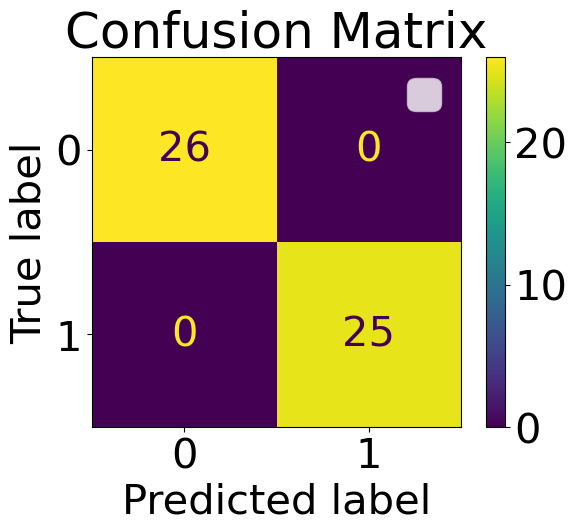

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        25

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



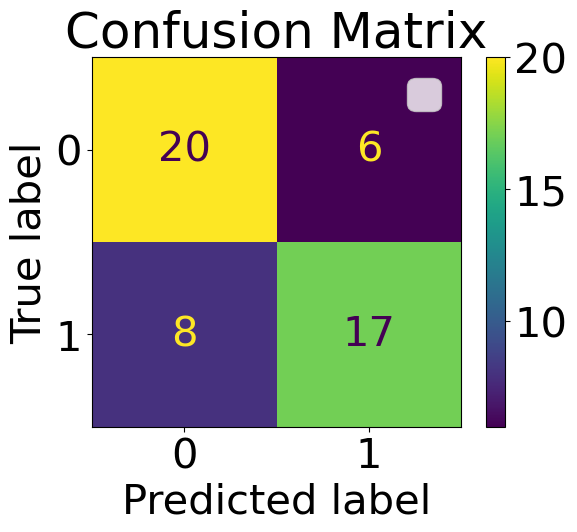

              precision    recall  f1-score   support

           0       0.71      0.77      0.74        26
           1       0.74      0.68      0.71        25

    accuracy                           0.73        51
   macro avg       0.73      0.72      0.72        51
weighted avg       0.73      0.73      0.72        51



In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
#from sklearn.qda import QDA

qdamod = QuadraticDiscriminantAnalysis()
qdamod.fit(train_x, train_y_math)


math_simple_train_preds = (qdamod.predict(train_x) >= 0.5).astype(int)
math_simple_test_preds = (qdamod.predict(test_x) >= 0.5).astype(int)


class_report(train_y_math, math_simple_train_preds)
class_report(test_y_math, math_simple_test_preds)


# QDA Reading


/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


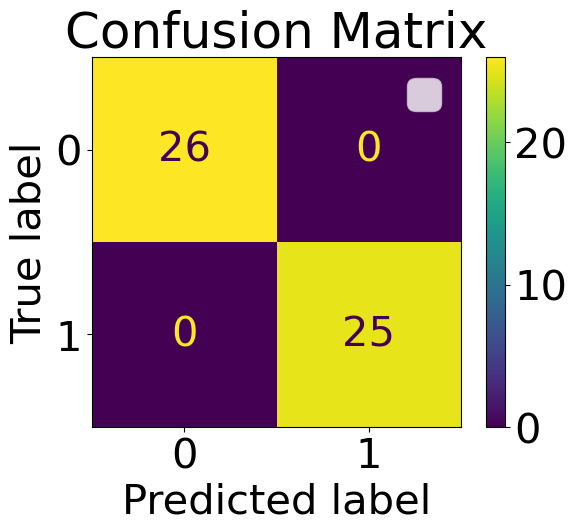

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        25

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



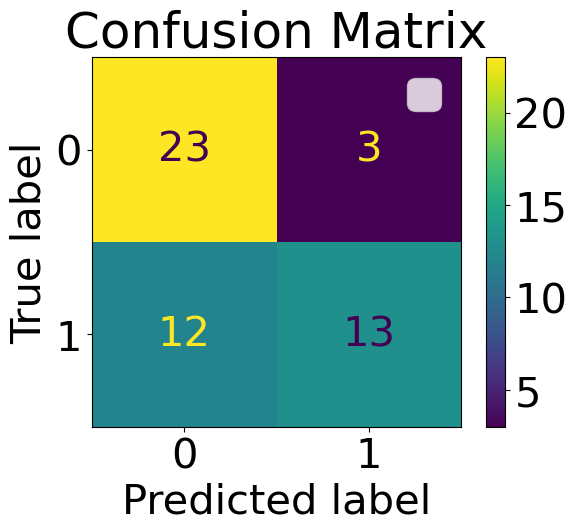

              precision    recall  f1-score   support

           0       0.66      0.88      0.75        26
           1       0.81      0.52      0.63        25

    accuracy                           0.71        51
   macro avg       0.73      0.70      0.69        51
weighted avg       0.73      0.71      0.70        51



In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
#from sklearn.qda import QDA

qdamod = QuadraticDiscriminantAnalysis()
qdamod.fit(train_x, train_y_reading)


rd_simple_train_preds = (qdamod.predict(train_x) >= 0.5).astype(int)
rd_simple_test_preds = (qdamod.predict(test_x) >= 0.5).astype(int)


class_report(train_y_reading, rd_simple_train_preds)
class_report(test_y_reading, rd_simple_test_preds)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


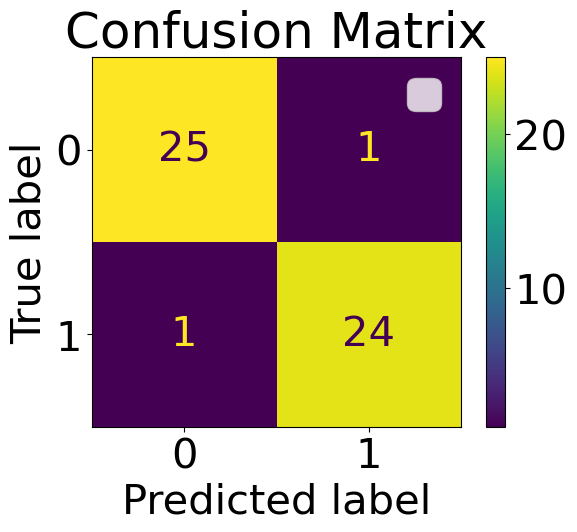

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.96      0.96      0.96        25

    accuracy                           0.96        51
   macro avg       0.96      0.96      0.96        51
weighted avg       0.96      0.96      0.96        51



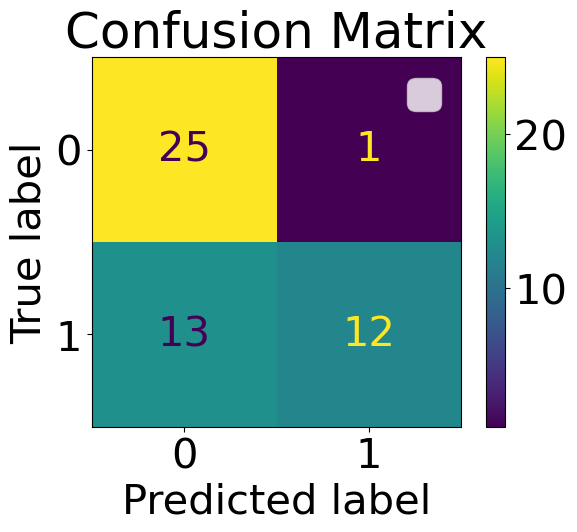

              precision    recall  f1-score   support

           0       0.66      0.96      0.78        26
           1       0.92      0.48      0.63        25

    accuracy                           0.73        51
   macro avg       0.79      0.72      0.71        51
weighted avg       0.79      0.73      0.71        51



In [10]:
ldamod = LinearDiscriminantAnalysis()
ldamod.fit(train_x, train_y_math)


rd_simple_train_preds = (ldamod.predict(train_x) >= 0.5).astype(int)
rd_simple_test_preds = (ldamod.predict(test_x) >= 0.5).astype(int)


class_report(train_y_math, rd_simple_train_preds)
class_report(test_y_math, rd_simple_test_preds)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


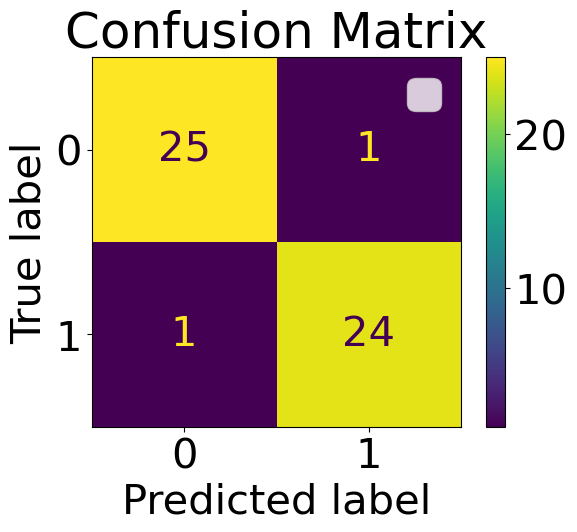

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.96      0.96      0.96        25

    accuracy                           0.96        51
   macro avg       0.96      0.96      0.96        51
weighted avg       0.96      0.96      0.96        51



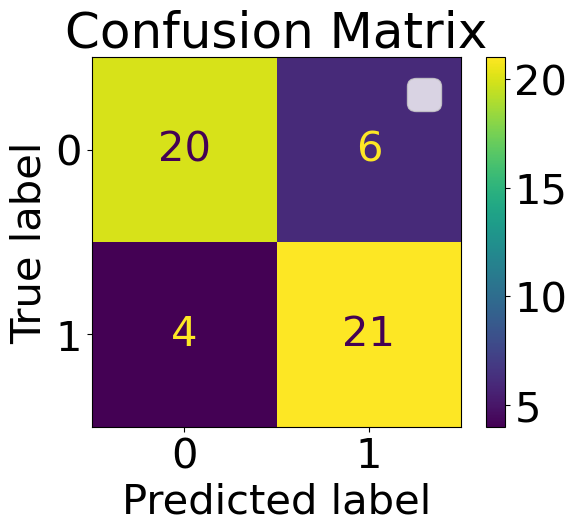

              precision    recall  f1-score   support

           0       0.83      0.77      0.80        26
           1       0.78      0.84      0.81        25

    accuracy                           0.80        51
   macro avg       0.81      0.80      0.80        51
weighted avg       0.81      0.80      0.80        51



In [9]:
ldamod = LinearDiscriminantAnalysis()
ldamod.fit(train_x, train_y_reading)


rd_simple_train_preds = (ldamod.predict(train_x) >= 0.5).astype(int)
rd_simple_test_preds = (ldamod.predict(test_x) >= 0.5).astype(int)


class_report(train_y_reading, rd_simple_train_preds)
class_report(test_y_reading, rd_simple_test_preds)